# 휴대폰 브랜드 이탈 고객 조사 - 머신러닝 훈련

In [86]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 모델 학습 (Random Forest)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 데이터 전처리 & 최적화
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel


# 모델 평가
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# 폰트 한글화 세팅

# # window font setting
# font_path = 'C:/Windows/Fonts/batang.ttc'           # 한글 폰트를 적용하여 시각화

# # PJE font setting
# plt.rcParams['font.family'] = 'Malgun Gothic' 

# mac font setting
font_path = '/Library/Fonts/Arial Unicode.ttf'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

# CSV 파일 읽기
phone_df = pd.read_csv('./data/phone_information.csv', low_memory=False)

### 컬럼명 정리 (21, 22, 23)

| 원본 컬럼명                     | 정리된 컬럼명        |
|---------------------------------|-------------------|
| 고객 고유 번호                | pid                 |
| 스마트폰 제조사                | brand               |
| 이메일                          | email               |
| 메신저                          | messenger           |
| 블로그                          | blog                |
| 클라우드                        | cloud               |
| 온라인 음성통화 여부               | call_check          |
| 년간 서비스 구매 이용 채널          | service_purchase    |
| 모바일 간편 송금                  | money_transfer      |
| 신용카드 저장 (모바일에 신용카드 저장) | credit_card       |
| 통신사 가격                      | agency_purchase     |
| 기기 가격                       | machine_purchase    |
| 가격 부담(부모 or 자신)           | phone_owner         |
| 스마트폰 구분 (데이터 구별)      | data                |
| 스마트폰 DMB 기능             | dmb                 |
| 스마트폰 통신사                | agency              |
| 음성 무제한 서비스 유무        | voice_service       |
| 데이터 무제한 서비스 유무      | data_service        |
| 스마트폰 사용 기간             | use_date            |
| 나이                        | age                 |
| 최종 학력 (학교별로 0~6)        | school              |
| 혼인 유무 (1~4)              | marry               |
| 월평균 소득 (평균 소득 1~18)    | salary              |
| 직업 유무 (직업 유무)          | job                 |
| 종교 유무 (종교 유무)          | religion            |

실 데이터 훈련 수

- total_merged  이탈자를 합한 총 데이터
- total_chaged  이탈자 데이터
    - 이탈자의 총 비율 total_changed / totla_merged

In [64]:
# column 데이터
selected_features_21 = [
    'machine_purchase_21',
    'agency_purchase_21',
    'data_service_21',
    'salary_21',
    'age_21',
    'cloud_21',
    'service_purchase_21',
    'use_date_21',
    'phone_owner_21',
    'money_transfer_21'
]

selected_features_22 = [
    'machine_purchase_22',
    'agency_purchase_22',
    'data_service_22',
    'salary_22',
    'age_22',
    'cloud_22',
    'service_purchase_22',
    'use_date_22',
    'phone_owner_22',
    'money_transfer_22'
]


# 범주형 변수 전처리
le = LabelEncoder()
categorical_features_21 = ['service_purchase_21', 'money_transfer_21']
categorical_features_22 = [
    'machine_purchase_22',
    'agency_purchase_22',
    'data_service_22',
    'use_date_22',
    'phone_owner_22',
    'service_purchase_22',
    'money_transfer_22'
]

# 범주형 변수 인코딩
for feature in categorical_features_21:
    phone_df[feature] = le.fit_transform(phone_df[feature].astype(str))

for feature in categorical_features_22:
    phone_df[feature] = le.fit_transform(phone_df[feature].astype(str))


In [ ]:
# # 원하는 부분에 모델 저장
# import joblib

# # Random Forest 모델 저장
# joblib.dump(rf_clf, 'models/random_forest_model.joblib')
# joblib.dump(xgb_clf, 'models/xgboost_model.joblib')

# # 특성 중요도와 성능 지표 저장
# import json
# model_metrics = {
#     'accuracy': rf_accuracy,
#     'f1_score': f1_score(y_test, rf_pred),
#     'feature_importance': rf_clf.feature_importances_.tolist(),
#     'feature_names': selected_features
# }

# with open('models/rf_metrics.json', 'w') as f:
#     json.dump(model_metrics, f)

# xgb_model_metrics = {
#     'accuracy': xgb_accuracy,
#     'f1_score': f1_score(y_test, xgb_pred),
#     'feature_importance': xgb_clf.feature_importances_.tolist(),
#     'feature_names': selected_features
# }

# with open('models/xgb_metrics.json', 'w') as f:
#     json.dump(xgb_model_metrics, f)

Random Forest 성능:               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1360
           1       0.38      0.03      0.05       118

    accuracy                           0.92      1478
   macro avg       0.65      0.51      0.50      1478
weighted avg       0.88      0.92      0.88      1478

Random Forest 정확도: 0.9188
XGBoost 성능:               precision    recall  f1-score   support

           0       0.92      0.99      0.96      1360
           1       0.23      0.03      0.05       118

    accuracy                           0.92      1478
   macro avg       0.58      0.51      0.50      1478
weighted avg       0.87      0.92      0.88      1478

XGBoost 정확도: 0.9154


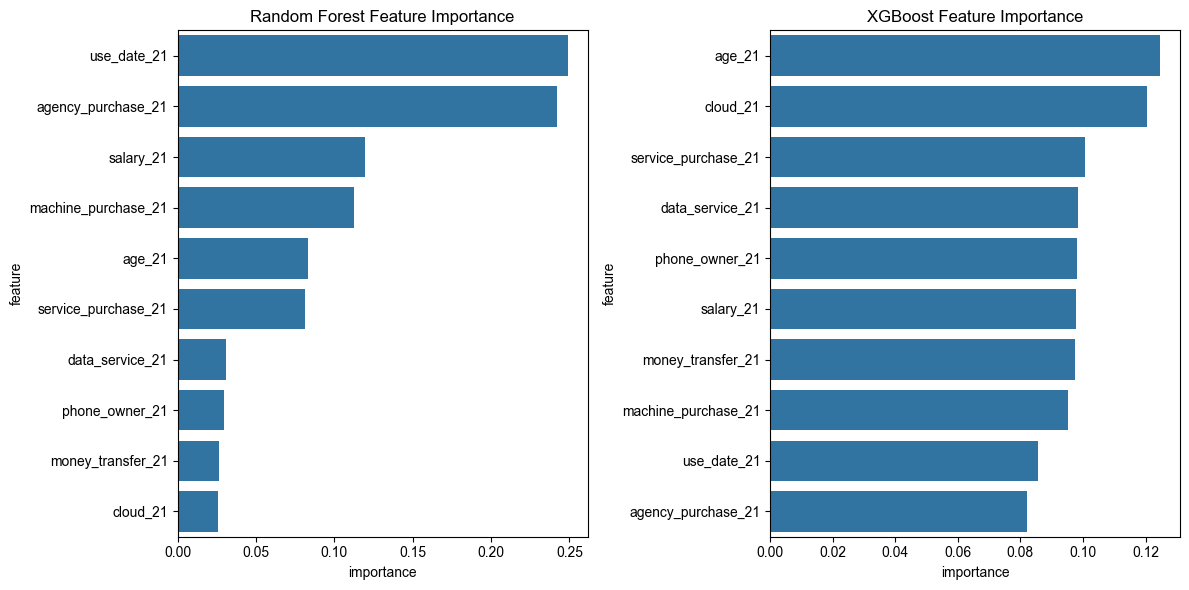

앙상블 모델 성능:               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1360
           1       0.25      0.01      0.02       118

    accuracy                           0.92      1478
   macro avg       0.59      0.50      0.49      1478
weighted avg       0.87      0.92      0.88      1478

앙상블 정확도: 0.9188


In [66]:
# 2022년도 이탈자에 대한 데이터 훈련 (랜덤포레스트 + XGBoost)

# 데이터 X, y
X = phone_df[selected_features_21]
y = (phone_df['brand_22'] != 1).astype(int)

# 데이터 훈련
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest 모델 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# XGBoost 모델 학습
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train, y_train)

# 예측 및 평가
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
xgb_pred = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

print(f"Random Forest 성능: {classification_report(y_test, rf_pred)}")
print(f"Random Forest 정확도: {rf_accuracy:.4f}")

print(f"XGBoost 성능: {classification_report(y_test, xgb_pred)}")
print(f"XGBoost 정확도: {xgb_accuracy:.4f}")

# Random Forest 특성 중요도
plt.figure(figsize=(12, 6))
importance_rf = pd.DataFrame({
    'feature': selected_features_21,
    'importance': rf_clf.feature_importances_
})
importance_rf = importance_rf.sort_values('importance', ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(data=importance_rf, x='importance', y='feature')
plt.title('Random Forest Feature Importance')

# XGBoost 특성 중요도
importance_xgb = pd.DataFrame({
    'feature': selected_features_21,
    'importance': xgb_clf.feature_importances_
})
importance_xgb = importance_xgb.sort_values('importance', ascending=False)

plt.subplot(1, 2, 2)
sns.barplot(data=importance_xgb, x='importance', y='feature')
plt.title('XGBoost Feature Importance')


plt.tight_layout()
plt.show()

ensemble_pred = (rf_pred + xgb_pred) / 2
ensemble_pred = (ensemble_pred > 0.5).astype(int)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)


print(f"앙상블 모델 성능: {classification_report(y_test, ensemble_pred)}")

print(f"앙상블 정확도: {ensemble_accuracy:.4f}")

Random Forest 성능:               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1389
           1       0.40      0.02      0.04        89

    accuracy                           0.94      1478
   macro avg       0.67      0.51      0.51      1478
weighted avg       0.91      0.94      0.91      1478

Random Forest 정확도: 0.9391
XGBoost 성능:               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1389
           1       0.25      0.07      0.11        89

    accuracy                           0.93      1478
   macro avg       0.60      0.53      0.54      1478
weighted avg       0.90      0.93      0.91      1478

XGBoost 정확도: 0.9317


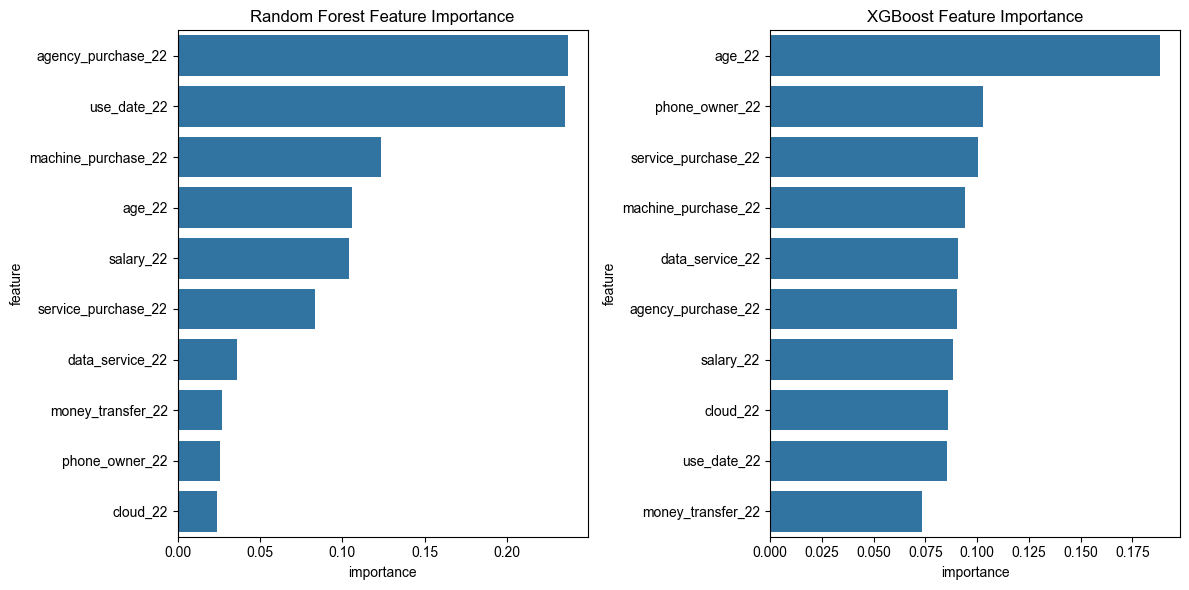

앙상블 모델 성능:               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1389
           1       0.50      0.02      0.04        89

    accuracy                           0.94      1478
   macro avg       0.72      0.51      0.51      1478
weighted avg       0.91      0.94      0.91      1478

앙상블 정확도: 0.9398


In [67]:
# 2023년도 이탈자에 대한 데이터 훈련 (랜덤포레스트 + XGBoost)

# 데이터 X, y
X = phone_df[selected_features_22]
y = (phone_df['brand_23'] != 1).astype(int)

# 데이터 훈련
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# XGBoost
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train, y_train)

# 예측 및 평가
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
xgb_pred = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

print(f"Random Forest 성능: {classification_report(y_test, rf_pred)}")
print(f"Random Forest 정확도: {rf_accuracy:.4f}")

print(f"XGBoost 성능: {classification_report(y_test, xgb_pred)}")
print(f"XGBoost 정확도: {xgb_accuracy:.4f}")

# Random Forest 특성 중요도
plt.figure(figsize=(12, 6))
importance_rf = pd.DataFrame({
    'feature': selected_features_22,
    'importance': rf_clf.feature_importances_
})
importance_rf = importance_rf.sort_values('importance', ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(data=importance_rf, x='importance', y='feature')
plt.title('Random Forest Feature Importance')

# XGBoost 특성 중요도
importance_xgb = pd.DataFrame({
    'feature': selected_features_22,
    'importance': xgb_clf.feature_importances_
})
importance_xgb = importance_xgb.sort_values('importance', ascending=False)

plt.subplot(1, 2, 2)
sns.barplot(data=importance_xgb, x='importance', y='feature')
plt.title('XGBoost Feature Importance')


plt.tight_layout()
plt.show()

ensemble_pred = (rf_pred + xgb_pred) / 2
ensemble_pred = (ensemble_pred > 0.5).astype(int)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)


print(f"앙상블 모델 성능: {classification_report(y_test, ensemble_pred)}")
print(f"앙상블 정확도: {ensemble_accuracy:.4f}")

Decision Tree 성능:               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1360
           1       0.00      0.00      0.00       118

    accuracy                           0.92      1478
   macro avg       0.46      0.50      0.48      1478
weighted avg       0.85      0.92      0.88      1478

Decision Tree 정확도: 0.9175
XGBoost 성능:               precision    recall  f1-score   support

           0       0.92      0.99      0.96      1360
           1       0.20      0.03      0.05       118

    accuracy                           0.91      1478
   macro avg       0.56      0.51      0.50      1478
weighted avg       0.86      0.91      0.88      1478

XGBoost 정확도: 0.9141
앙상블 성능:              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1360
           1       0.00      0.00      0.00       118

    accuracy                           0.92      1478
   macro avg       0.46      0.50      0.48  

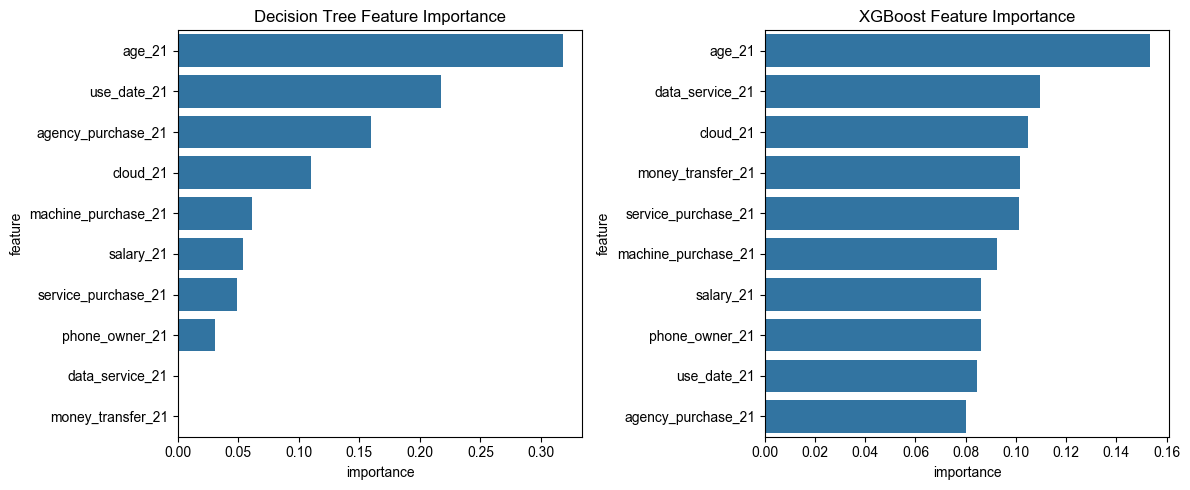

In [68]:
# 2022년도 이탈자에 대한 데이터 훈련 (결정트리 + XGBoost)

X = phone_df[selected_features_21]
y = (phone_df['brand_22'] != 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(max_depth=5, random_state=42)
xgb_clf.fit(X_train, y_train)

dt_pred = dt_clf.predict(X_test)
xgb_pred = xgb_clf.predict(X_test)

ensemble_pred = ((dt_pred + xgb_pred) / 2 > 0.5).astype(int)

print(f"Decision Tree 성능: {classification_report(y_test, dt_pred)}")
print(f"Decision Tree 정확도: {accuracy_score(y_test, dt_pred):.4f}")

print(f"XGBoost 성능: {classification_report(y_test, xgb_pred)}")
print(f"XGBoost 정확도: {accuracy_score(y_test, xgb_pred):.4f}")

print(f"앙상블 성능:{classification_report(y_test, ensemble_pred)}")
print(f"앙상블 정확도: {accuracy_score(y_test, ensemble_pred):.4f}")

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
importance_dt = pd.DataFrame({
    'feature': selected_features_21,    
    'importance': dt_clf.feature_importances_
})
importance_dt = importance_dt.sort_values('importance', ascending=False)
sns.barplot(data=importance_dt, x='importance', y='feature')
plt.title('Decision Tree Feature Importance')

plt.subplot(1, 2, 2)
importance_xgb = pd.DataFrame({
    'feature': selected_features_21,
    'importance': xgb_clf.feature_importances_
})
importance_xgb = importance_xgb.sort_values('importance', ascending=False)
sns.barplot(data=importance_xgb, x='importance', y='feature')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

Decision Tree 성능:               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1389
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1478
   macro avg       0.47      0.50      0.48      1478
weighted avg       0.88      0.94      0.91      1478

Decision Tree 정확도: 0.9398
XGBoost 성능:               precision    recall  f1-score   support

           0       0.94      0.99      0.97      1389
           1       0.22      0.04      0.07        89

    accuracy                           0.93      1478
   macro avg       0.58      0.52      0.52      1478
weighted avg       0.90      0.93      0.91      1478

XGBoost 정확도: 0.9330
앙상블 성능:              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1389
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1478
   macro avg       0.47      0.50      0.48  

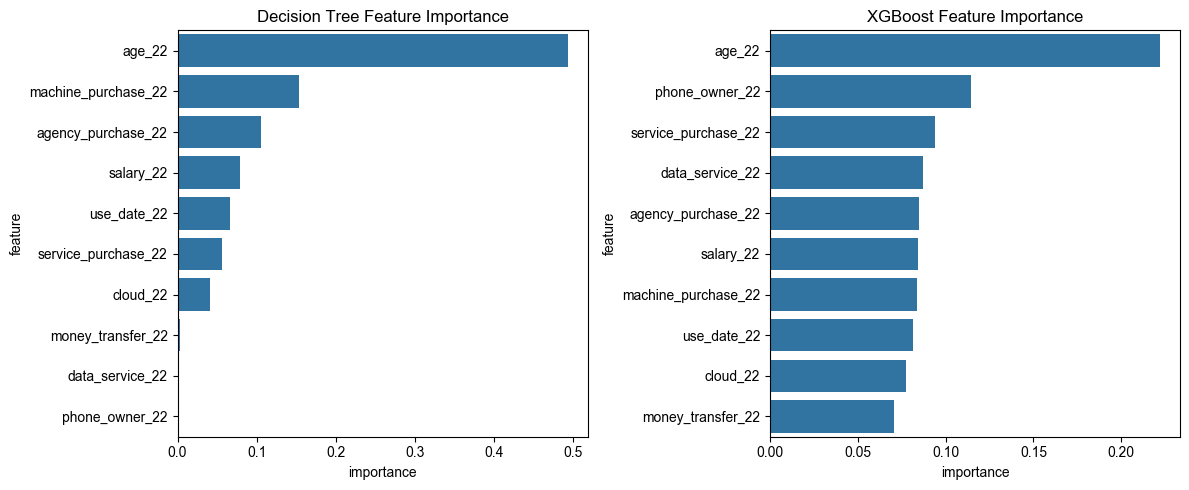

In [69]:
# 2023년도 이탈자에 대한 데이터 훈련 (결정트리 + XGBoost)

X = phone_df[selected_features_22]
y = (phone_df['brand_23'] != 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(max_depth=5, random_state=42)
xgb_clf.fit(X_train, y_train)

dt_pred = dt_clf.predict(X_test)
xgb_pred = xgb_clf.predict(X_test)

ensemble_pred = ((dt_pred + xgb_pred) / 2 > 0.5).astype(int)

print(f"Decision Tree 성능: {classification_report(y_test, dt_pred)}")
print(f"Decision Tree 정확도: {accuracy_score(y_test, dt_pred):.4f}")

print(f"XGBoost 성능: {classification_report(y_test, xgb_pred)}")
print(f"XGBoost 정확도: {accuracy_score(y_test, xgb_pred):.4f}")

print(f"앙상블 성능:{classification_report(y_test, ensemble_pred)}")
print(f"앙상블 정확도: {accuracy_score(y_test, ensemble_pred):.4f}")

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
importance_dt = pd.DataFrame({
    'feature': selected_features_22,    
    'importance': dt_clf.feature_importances_
})
importance_dt = importance_dt.sort_values('importance', ascending=False)
sns.barplot(data=importance_dt, x='importance', y='feature')
plt.title('Decision Tree Feature Importance')

plt.subplot(1, 2, 2)
importance_xgb = pd.DataFrame({
    'feature': selected_features_22,
    'importance': xgb_clf.feature_importances_
})
importance_xgb = importance_xgb.sort_values('importance', ascending=False)
sns.barplot(data=importance_xgb, x='importance', y='feature')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

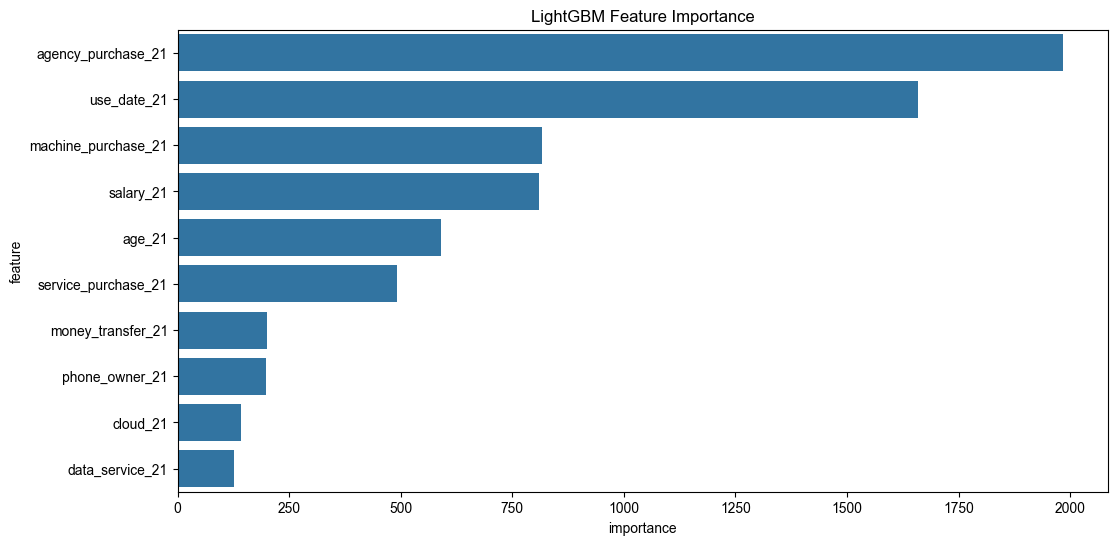

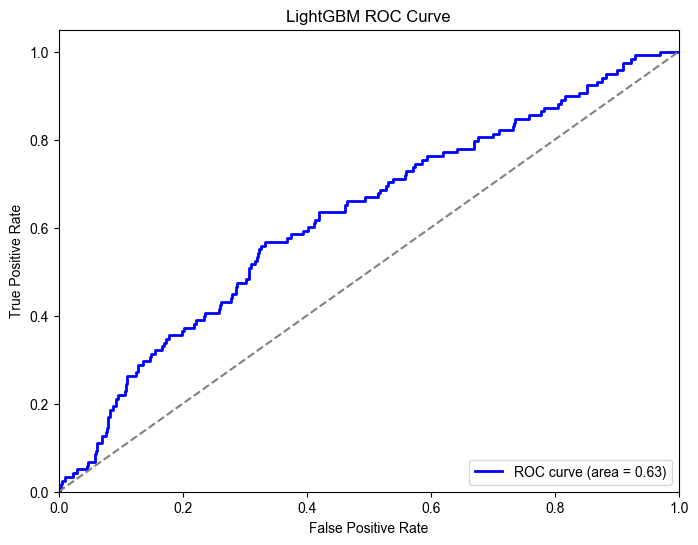

LightGBM 성능:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1360
           1       0.00      0.00      0.00       118

    accuracy                           0.92      1478
   macro avg       0.46      0.50      0.48      1478
weighted avg       0.85      0.92      0.88      1478

LightGBM 정확도: 0.9195


In [82]:
# 데이터 다시 분할 (필요할 경우)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBM 모델 설정
GBM_lgb_clf = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)

# 모델 학습
GBM_lgb_clf.fit(X_train, y_train)

# 예측 및 평가
GBM_lgb_pred = GBM_lgb_clf.predict(X_test)
GBM_lgb_accuracy = accuracy_score(y_test, GBM_lgb_pred)

# ✅ 수정된 코드: LightGBM 예측값을 사용하도록 변경
GBM_classification_rep = classification_report(y_test, GBM_lgb_pred)

# LightGBM 특성 중요도 계산 및 정렬
importance_gb = pd.DataFrame({
    'feature': selected_features_21,
    'importance': GBM_lgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_gb, x='importance', y='feature')
plt.title('LightGBM Feature Importance')
plt.show()

# ROC 커브 계산
GBM_fpr, GBM_tpr, _ = roc_curve(y_test, GBM_lgb_clf.predict_proba(X_test)[:, 1])
GBM_roc_auc = auc(GBM_fpr, GBM_tpr)

# ✅ 수정된 코드: `gb_roc_auc` -> `GBM_roc_auc`
plt.figure(figsize=(8, 6))
plt.plot(GBM_fpr, GBM_tpr, color='blue', lw=2, label=f'ROC curve (area = {GBM_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend(loc="lower right")
plt.show()

# LightGBM 성능 출력
print("LightGBM 성능:")
print(GBM_classification_rep)
print(f"LightGBM 정확도: {GBM_lgb_accuracy:.4f}")


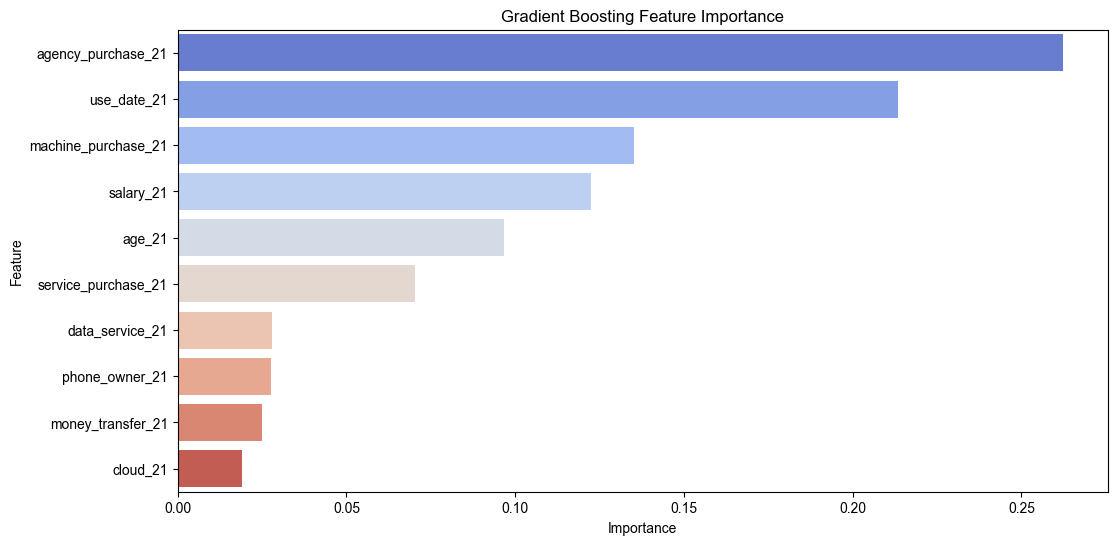

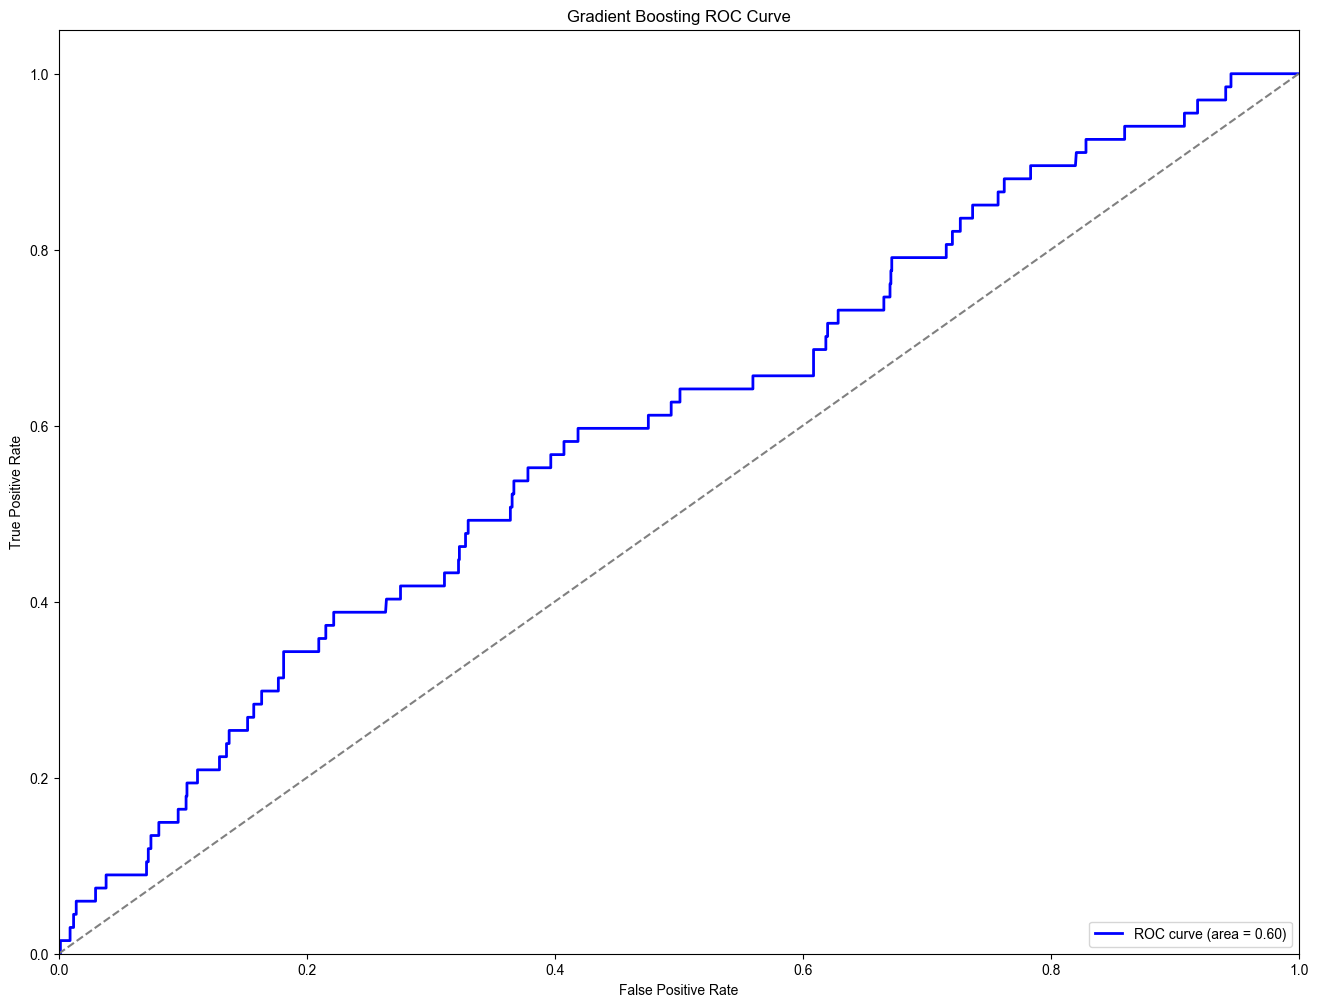

Gradient Boosting Classification Report:
Gradient Boosting Accuracy: 0.9540
Gradient Boosting 성능:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1411
           1       0.33      0.01      0.03        67

    accuracy                           0.95      1478
   macro avg       0.64      0.51      0.50      1478
weighted avg       0.93      0.95      0.93      1478

Gradient Boosting 정확도: 0.9540


In [84]:
# 결측값을 0으로 채우기 (다른 방법이 있을시 변경)
phone_df[selected_features_21] = phone_df[selected_features_21].fillna(0)

# X, Y 정의
X = phone_df[selected_features_21]
y = ((phone_df['brand_21'] == 1) & (phone_df['brand_22'] != 1)).astype(int)

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Gradient Boosting Model 학습
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
gb_clf.fit(X_train, y_train)

# 예측및 평가
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_classification_report = classification_report(y_test, gb_pred)

# 특성 중요도
gb_feature_importance = pd.DataFrame({
    'Feature': selected_features_21,
    'Importance': gb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 시각화 - Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(data=gb_feature_importance.head(20), x='Importance', y='Feature', palette='coolwarm')
plt.title('Gradient Boosting Feature Importance')
plt.show()

# ROC Curve
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_clf.predict_proba(X_test)[:, 1])
gb_roc_auc = auc(gb_fpr, gb_tpr)

plt.figure(figsize=(16, 12))
plt.plot(gb_fpr, gb_tpr, color='blue', lw=2, label=f'ROC curve (area = {gb_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 결과 출력
print("Gradient Boosting Classification Report:")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")
print(f"Gradient Boosting 성능: {classification_report(y_test, gb_pred)}")
print(f"Gradient Boosting 정확도: {gb_accuracy:.4f}")


---
### 이탈자의 데이터가 현저하게 적기 때문에 데이터 훈련 시 적게 나오게된다

이탈자 데이터에서 소수 클래스(이탈자)의 성능을 높이기 위한 몇 가지 방법 적용
1. SMOTE(Synthetic Minority Over-sampling Technique) 사용
2. 클래스 가중치 적용
3. 결정 임계값 조정

In [70]:
# 2. X, y 데이터 준비
X = phone_df[selected_features_21]
y = (phone_df['brand_22'] != 1).astype(int)

# 3. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 5. 모델 학습
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_balanced, y_train_balanced)

# XGBoost
xgb_model = XGBClassifier(max_depth=5, random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)

# 6. 예측
dt_pred = dt_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# 앙상블 예측
ensemble_pred = ((dt_pred + xgb_pred) / 2 > 0.5).astype(int)

# 7. 성능 평가
print("SMOTE 적용 후 성능 평가")
print("\nDecision Tree 성능:")
print(classification_report(y_test, dt_pred))
print(f"Decision Tree 정확도: {accuracy_score(y_test, dt_pred):.4f}")

print("\nXGBoost 성능:")
print(classification_report(y_test, xgb_pred))
print(f"XGBoost 정확도: {accuracy_score(y_test, xgb_pred):.4f}")

print("\n앙상블 성능:")
print(classification_report(y_test, ensemble_pred))
print(f"앙상블 정확도: {accuracy_score(y_test, ensemble_pred):.4f}")

# 8. SMOTE 전후 클래스 분포 비교
print("\n클래스 분포 비교:")
print("원본 학습 데이터:", np.bincount(y_train))
print("SMOTE 적용 후:", np.bincount(y_train_balanced))

# 9. 특성 중요도 시각화
plt.figure(figsize=(12, 5))

SMOTE 적용 후 성능 평가

Decision Tree 성능:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1360
           1       0.13      0.34      0.19       118

    accuracy                           0.76      1478
   macro avg       0.53      0.57      0.52      1478
weighted avg       0.87      0.76      0.81      1478

Decision Tree 정확도: 0.7645

XGBoost 성능:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1360
           1       0.13      0.25      0.17       118

    accuracy                           0.80      1478
   macro avg       0.53      0.55      0.53      1478
weighted avg       0.87      0.80      0.83      1478

XGBoost 정확도: 0.8038

앙상블 성능:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1360
           1       0.15      0.16      0.16       118

    accuracy                           0.86      1478
   macro avg       0.54 

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

클래스 가중치: {np.int64(0): np.float64(0.5432824848373461), np.int64(1): np.float64(6.2760084925690025)}

클래스 가중치 적용 후 성능 평가

Decision Tree 성능:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1360
           1       0.11      0.53      0.18       118

    accuracy                           0.61      1478
   macro avg       0.52      0.58      0.46      1478
weighted avg       0.87      0.61      0.70      1478

Decision Tree 정확도: 0.6110

XGBoost 성능:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1360
           1       0.13      0.37      0.19       118

    accuracy                           0.75      1478
   macro avg       0.53      0.58      0.52      1478
weighted avg       0.87      0.75      0.80      1478

XGBoost 정확도: 0.7470

앙상블 성능:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1360
           1       0.14      0

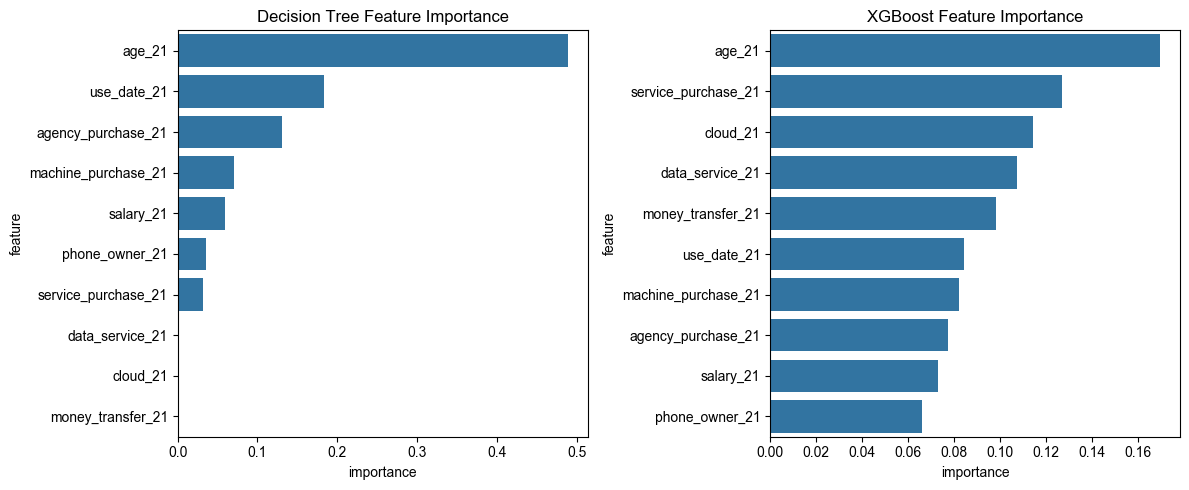

In [71]:
# 2. X, y 데이터 준비
X = phone_df[selected_features_21]
y = (phone_df['brand_22'] != 1).astype(int)

# 3. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("클래스 가중치:", class_weight_dict)

# 5. 모델 학습 (가중치 적용)
# Decision Tree with class weights
dt_model = DecisionTreeClassifier(
    max_depth=4, 
    random_state=42,
    class_weight=class_weight_dict
)
dt_model.fit(X_train, y_train)

# XGBoost with scale_pos_weight
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
xgb_model = XGBClassifier(
    max_depth=4, 
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb_model.fit(X_train, y_train)

# 6. 예측
dt_pred = dt_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# 앙상블 예측
ensemble_pred = ((dt_pred + xgb_pred) / 2 > 0.5).astype(int)

# 7. 성능 평가
print("\n클래스 가중치 적용 후 성능 평가")
print("\nDecision Tree 성능:")
print(classification_report(y_test, dt_pred))
print(f"Decision Tree 정확도: {accuracy_score(y_test, dt_pred):.4f}")

print("\nXGBoost 성능:")
print(classification_report(y_test, xgb_pred))
print(f"XGBoost 정확도: {accuracy_score(y_test, xgb_pred):.4f}")

print("\n앙상블 성능:")
print(classification_report(y_test, ensemble_pred))
print(f"앙상블 정확도: {accuracy_score(y_test, ensemble_pred):.4f}")

# 8. 클래스 분포 확인
print("\n클래스 분포:")
print("학습 데이터:", np.bincount(y_train))
print("테스트 데이터:", np.bincount(y_test))

# 9. 특성 중요도 시각화
plt.figure(figsize=(12, 5))

# Decision Tree 특성 중요도
plt.subplot(1, 2, 1)
importance_dt = pd.DataFrame({
    'feature': selected_features_21,
    'importance': dt_model.feature_importances_
})
importance_dt = importance_dt.sort_values('importance', ascending=False)
sns.barplot(data=importance_dt, x='importance', y='feature')
plt.title('Decision Tree Feature Importance')

# XGBoost 특성 중요도
plt.subplot(1, 2, 2)
importance_xgb = pd.DataFrame({
    'feature': selected_features_21,
    'importance': xgb_model.feature_importances_
})
importance_xgb = importance_xgb.sort_values('importance', ascending=False)
sns.barplot(data=importance_xgb, x='importance', y='feature')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()


임곗값 0.3일 때의 결과:

Decision Tree (threshold=0.3):
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1360
           1       0.10      0.03      0.05       118

    accuracy                           0.90      1478
   macro avg       0.51      0.50      0.50      1478
weighted avg       0.85      0.90      0.87      1478


XGBoost (threshold=0.3):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1360
           1       0.00      0.00      0.00       118

    accuracy                           0.92      1478
   macro avg       0.46      0.50      0.48      1478
weighted avg       0.85      0.92      0.88      1478


앙상블 (threshold=0.3):
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1360
           1       0.12      0.01      0.02       118

    accuracy                           0.92      1478
   macro avg       0.52      0.

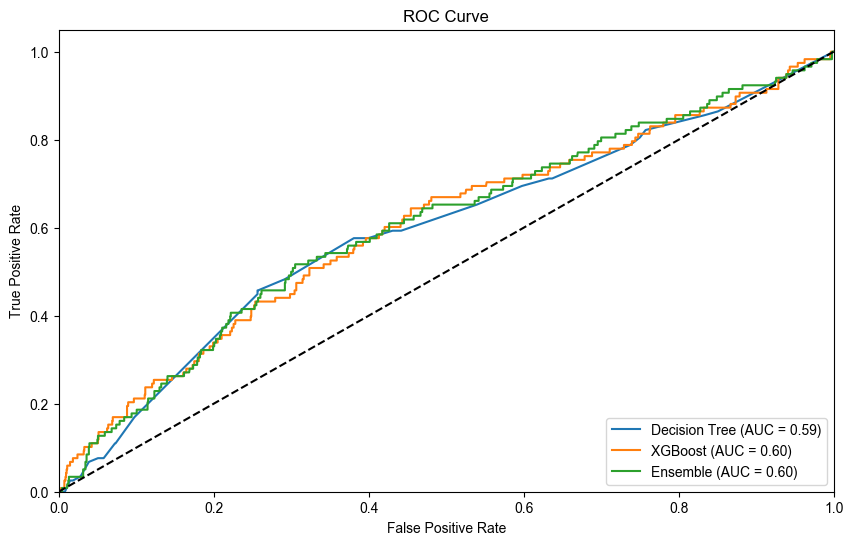

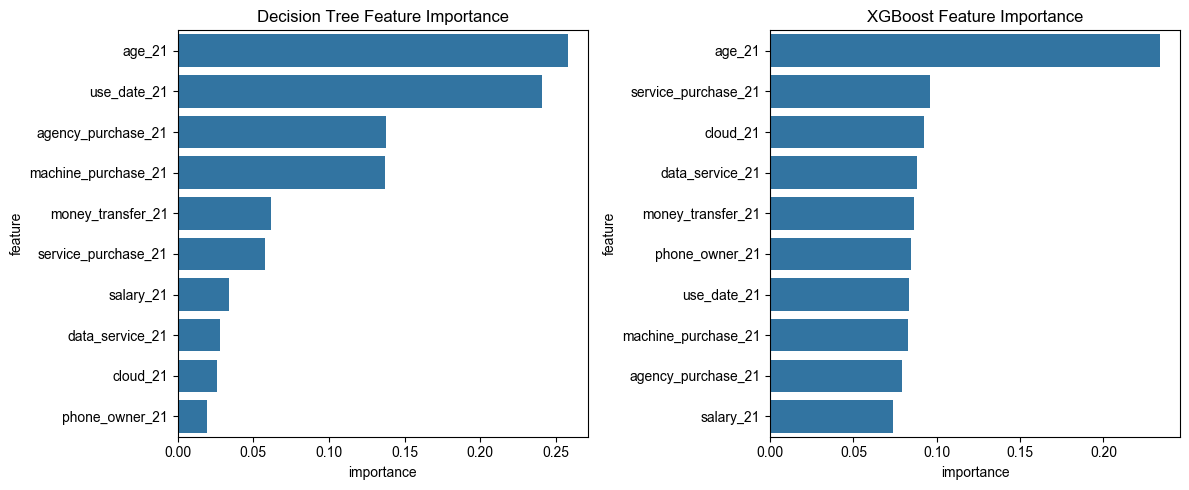

In [72]:

# 2. X, y 데이터 준비
X = phone_df[selected_features_21]
y = (phone_df['brand_22'] != 1).astype(int)

# 3. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 최적화된 모델 파라미터로 모델 정의
dt_model = DecisionTreeClassifier(
    max_depth=7,              # 트리 깊이 증가
    min_samples_split=10,     # 분할을 위한 최소 샘플 수
    min_samples_leaf=5,       # 리프 노드의 최소 샘플 수
    criterion='entropy',      # 정보 이득 기준
    random_state=42
)

xgb_model = XGBClassifier(
    max_depth=6,              # 트리 깊이
    learning_rate=0.01,       # 학습률 감소
    n_estimators=200,         # 트리 개수 증가
    min_child_weight=3,       # 과적합 방지
    subsample=0.8,            # 샘플링 비율
    colsample_bytree=0.8,     # 특성 샘플링
    random_state=42
)

# 5. 모델 학습
dt_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# 6. 예측 확률 계산
dt_proba = dt_model.predict_proba(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

# 7. 다양한 임곗값에 대한 결과 비교
thresholds = [0.3, 0.4, 0.5]
for threshold in thresholds:
    print(f"\n임곗값 {threshold}일 때의 결과:")
    
    # Decision Tree 예측
    dt_pred = (dt_proba[:, 1] > threshold).astype(int)
    print(f"\nDecision Tree (threshold={threshold}):")
    print(classification_report(y_test, dt_pred, zero_division=0))
    
    # XGBoost 예측
    xgb_pred = (xgb_proba[:, 1] > threshold).astype(int)
    print(f"\nXGBoost (threshold={threshold}):")
    print(classification_report(y_test, xgb_pred, zero_division=0))
    
    # 앙상블 예측
    ensemble_proba = (dt_proba[:, 1] + xgb_proba[:, 1]) / 2
    ensemble_pred = (ensemble_proba > threshold).astype(int)
    print(f"\n앙상블 (threshold={threshold}):")
    print(classification_report(y_test, ensemble_pred, zero_division=0))

plt.figure(figsize=(10, 6))

# Decision Tree ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# 앙상블 ROC
ensemble_proba = (dt_proba[:, 1] + xgb_proba[:, 1]) / 2
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_proba)
roc_auc_ens = auc(fpr_ens, tpr_ens)
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {roc_auc_ens:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 9. 특성 중요도 시각화
plt.figure(figsize=(12, 5))

# Decision Tree 특성 중요도
plt.subplot(1, 2, 1)
importance_dt = pd.DataFrame({
    'feature': selected_features_21,
    'importance': dt_model.feature_importances_
})
importance_dt = importance_dt.sort_values('importance', ascending=False)
sns.barplot(data=importance_dt, x='importance', y='feature')
plt.title('Decision Tree Feature Importance')

# XGBoost 특성 중요도
plt.subplot(1, 2, 2)
importance_xgb = pd.DataFrame({
    'feature': selected_features_21,
    'importance': xgb_model.feature_importances_
})
importance_xgb = importance_xgb.sort_values('importance', ascending=False)
sns.barplot(data=importance_xgb, x='importance', y='feature')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

In [73]:
# SMOTE 적용
rdos = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = rdos.fit_resample(X_train, y_train)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# 모델 정의
dt_model = DecisionTreeClassifier(
    max_depth=7,
    min_samples_leaf=5,
    random_state=42,
    class_weight=class_weight_dict
)

xgb_model = XGBClassifier(
    max_depth=7,
    learning_rate=0.2,
    n_estimators=100,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
)

# 모델 학습
dt_model.fit(X_train_balanced, y_train_balanced)
xgb_model.fit(X_train_balanced, y_train_balanced)

# 예측 확률 계산
dt_proba = dt_model.predict_proba(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

# 임곗값 조정
threshold = 0.3
dt_pred = (dt_proba[:, 1] > threshold).astype(int)
xgb_pred = (xgb_proba[:, 1] > threshold).astype(int)
ensemble_pred = ((dt_pred + xgb_pred) / 2 > 0.5).astype(int)

# 성능 평가
print("Decision Tree 성능:")
print(classification_report(y_test, dt_pred))

print("\nXGBoost 성능:")
print(classification_report(y_test, xgb_pred))

print("\n앙상블 성능:")
print(classification_report(y_test, ensemble_pred))

Decision Tree 성능:
              precision    recall  f1-score   support

           0       0.93      0.07      0.12      1360
           1       0.08      0.94      0.15       118

    accuracy                           0.14      1478
   macro avg       0.50      0.50      0.14      1478
weighted avg       0.86      0.14      0.13      1478


XGBoost 성능:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72      1360
           1       0.10      0.54      0.17       118

    accuracy                           0.58      1478
   macro avg       0.52      0.56      0.45      1478
weighted avg       0.87      0.58      0.68      1478


앙상블 성능:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72      1360
           1       0.10      0.54      0.17       118

    accuracy                           0.58      1478
   macro avg       0.52      0.56      0.45      1478
weighted avg       0.87      0.58 

In [74]:
class ChurnPredictor:
    def __init__(self, df, target_year):
        self.df = df.copy()  # 데이터 복사본 생성
        self.target_year = target_year
        self.base_year = target_year - 1
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        
    def preprocess_data(self):
        """데이터 전처리"""
        # 1. 초기 특성 선택
        self.features = [col for col in self.df.columns if str(self.base_year) in col]
        df_clean = self.df.copy()
        
        # 2. 결측치 처리
        for col in self.features:
            if df_clean[col].dtype in ['int64', 'float64']:
                df_clean[col] = df_clean[col].fillna(df_clean[col].mean())
            else:
                df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
        
        # 3. 특성 엔지니어링
        df_clean[f'price_to_income_{self.base_year}'] = (
            df_clean[f'machine_purchase_{self.base_year}'] / 
            (df_clean[f'salary_{self.base_year}'] + 1)  # 0으로 나누기 방지
        )
        
        df_clean[f'total_cost_{self.base_year}'] = (
            df_clean[f'machine_purchase_{self.base_year}'] + 
            df_clean[f'agency_purchase_{self.base_year}']
        )
        
        service_cols = [col for col in self.features if 'service' in col]
        df_clean[f'service_usage_score_{self.base_year}'] = df_clean[service_cols].sum(axis=1)
        
        # 4. 범주형 변수 인코딩
        categorical_cols = df_clean[self.features].select_dtypes(include=['object']).columns
        for col in categorical_cols:
            df_clean[col] = self.le.fit_transform(df_clean[col].astype(str))
        
        # 5. 특성 스케일링
        numeric_cols = df_clean[self.features].select_dtypes(include=['int64', 'float64']).columns
        scaled_features = self.scaler.fit_transform(df_clean[numeric_cols])
        df_clean[numeric_cols] = pd.DataFrame(scaled_features, index=df_clean.index, columns=numeric_cols)
        
        return df_clean
    
    def prepare_xy(self, df_clean):
        """X, y 데이터 준비"""
        # 기존 특성에 새로 생성된 특성들 추가
        all_features = self.features.copy()
        all_features.extend([
            f'price_to_income_{self.base_year}',
            f'total_cost_{self.base_year}',
            f'service_usage_score_{self.base_year}'
        ])
        
        X = df_clean[all_features]
        y = (df_clean[f'brand_{self.target_year}'] != 1).astype(int)
        return X, y
    
    def create_ensemble(self):
        """앙상블 모델 생성"""
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=7,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42
        )
        
        xgb = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        
        lgb = LGBMClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.01,
            subsample=0.8,
            random_state=42,
            verbose=-1,  # 경고 메시지 제거
            force_col_wise=True  # col-wise 경고 제거
        )
        
        return VotingClassifier(
            estimators=[
                ('rf', rf),
                ('xgb', xgb),
                ('lgb', lgb)
            ],
            voting='soft'
        )
    
    def train_and_evaluate(self):
        """전체 훈련 및 평가 프로세스"""
        print("데이터 전처리 중...")
        df_clean = self.preprocess_data()
        X, y = self.prepare_xy(df_clean)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print("데이터 불균형 처리 중...")
        ros = RandomOverSampler(random_state=42)
        X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
        
        print("중요 특성 선택 중...")
        selector = SelectFromModel(
            RandomForestClassifier(n_estimators=100, random_state=42),
            max_features=20
        )
        selector.fit(X_train_balanced, y_train_balanced)
        X_train_selected = selector.transform(X_train_balanced)
        selected_features = X.columns[selector.get_support()].tolist()
        X_test_selected = X_test[selected_features]
        
        print("모델 학습 중...")
        model = self.create_ensemble()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_selected, y_train_balanced)
        
        print("\n다양한 임계값에서의 성능 평가:")
        y_pred_proba = model.predict_proba(X_test_selected)
        
        thresholds = [0.5, 0.6]
        best_threshold = 0
        best_f1 = 0
        
        for threshold in thresholds:
            y_pred = (y_pred_proba[:, 1] > threshold).astype(int)
            report = classification_report(y_test, y_pred, output_dict=True)
            f1 = report['1']['f1-score']
            
            print(f"\nThreshold: {threshold}")
            print(classification_report(y_test, y_pred))
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        print(f"\n최적 임계값: {best_threshold} (F1-score: {best_f1:.4f})")
        
        return model, best_threshold, selected_features

# 모델 실행
import warnings
warnings.filterwarnings('ignore')  # 모든 경고 메시지 숨기기

predictor = ChurnPredictor(phone_df, target_year=22)
model, best_threshold, selected_features = predictor.train_and_evaluate()

데이터 전처리 중...
데이터 불균형 처리 중...
중요 특성 선택 중...
모델 학습 중...

다양한 임계값에서의 성능 평가:

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1360
           1       0.21      0.56      0.31       118

    accuracy                           0.80      1478
   macro avg       0.58      0.69      0.60      1478
weighted avg       0.90      0.80      0.84      1478


Threshold: 0.6
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1360
           1       0.28      0.42      0.34       118

    accuracy                           0.87      1478
   macro avg       0.62      0.66      0.63      1478
weighted avg       0.89      0.87      0.88      1478


최적 임계값: 0.6 (F1-score: 0.3368)


### 파생변수 추가

In [75]:
# 파생 변수

# 통신 서비스 활용도
phone_df['telecom_service_score'] = phone_df[['voice_service_21', 'data_service_21']].sum(axis=1)

# 생애주기 점수 (나이, 결혼여부, 직업 조합)
phone_df['lifecycle_score'] = phone_df['age_21'] + phone_df['marry_21'] * 10 + phone_df['job_21'] * 5

# 전체 서비스 사용 점수
phone_df['total_service_score'] = phone_df[['email_21', 'messenger_21', 'blog_21', 
                               'cloud_21', 'call_check_21']].sum(axis=1)
# 서비스 활용도와 소득 수준의 상호작용
phone_df['service_income_interaction'] = phone_df['total_service_score'] * phone_df['salary_21']

# 연령과 서비스 활용도의 상호작용
phone_df['age_service_interaction'] = phone_df['age_21'] * phone_df['total_service_score']

# 통신비와 서비스 활용도의 상호작용
phone_df['cost_service_interaction'] = phone_df['agency_purchase_21'] * phone_df['total_service_score']

# 월 통신비의 소득 대비 비율
phone_df['agency_to_income_ratio'] = phone_df['agency_purchase_21'] / phone_df['salary_21']

# 기기 가격의 소득 대비 비율
phone_df['device_to_income_ratio'] = phone_df['machine_purchase_21'] / phone_df['salary_21']

# 고객 소득 대비 비율
phone_df['cost_to_income_ratio'] = phone_df['agency_purchase_21'] / phone_df['salary_21']

# 전체 서비스 사용 점수
phone_df['total_service_score'] = phone_df[['email_21', 'messenger_21', 'blog_21', 'cloud_21', 'call_check_21']].sum(axis=1)

# 금융 서비스 활용도
phone_df['financial_service_score'] = phone_df[['money_transfer_21', 'credit_card_21']].sum(axis=1)

# 복합지표
# 고객 가치 점수
phone_df['customer_value_score'] = (phone_df['salary_21'] * 0.3 +phone_df['total_service_score'] * 0.3 +phone_df['agency_purchase_21'] * 0.2 +phone_df['use_date_21'] * 0.2)

### 이탈 위험 점수
phone_df['churn_risk_score'] = ((phone_df['cost_to_income_ratio'] * 0.4) + (phone_df['total_service_score'] / phone_df['total_service_score'].max()) * 0.3 + (phone_df['use_date_21'] / phone_df['use_date_21'].max()) * 0.3)

In [88]:
# 삼성 브랜드가 1, 기타 브랜드가 1이 아닌 값(2~9)
phone_df['churn'] = 0  # 기본값 0(이탈자가 아님)

phone_df.loc[
    (phone_df['brand_21'] == 1) & (phone_df['brand_22'] != 1) & (phone_df['brand_23'] != 1), 
    'churn'
] = 1  # 1-0-0 (삼성 → 기타 → 기타)

phone_df.loc[
    (phone_df['brand_21'] == 1) & (phone_df['brand_22'] == 1) & (phone_df['brand_23'] != 1), 
    'churn'
] = 1  # 1-1-0 (삼성 → 삼성 → 기타)

phone_df.loc[
    (phone_df['brand_21'] == 1) & (phone_df['brand_22'] != 1) & (phone_df['brand_23'] == 1), 
    'churn'
] = 1  # 1-0-1 (삼성 → 기타 → 삼성, 복귀자)

phone_df.loc[
    (phone_df['brand_21'] != 1) & (phone_df['brand_22'] == 1) & (phone_df['brand_23'] != 1), 
    'churn'
] = 1  # 0-1-0 (기타 → 삼성 → 기타)

In [89]:
from scipy.stats import skew

# 열 데이터를 숫자형으로 변환
columns_to_check = ['agency_purchase_21', 'machine_purchase_21', 'use_date_21', 'salary_21',
                    'agency_purchase_22', 'machine_purchase_22', 'use_date_22', 'salary_22']

# 변환 후 skew 계산
skew_values = {col: skew(phone_df[col].astype('float64')) for col in columns_to_check}

# 결과 출력
print(skew_values)


{'agency_purchase_21': np.float64(0.9074580057159947), 'machine_purchase_21': np.float64(2.176268547438348), 'use_date_21': np.float64(0.8555798979932648), 'salary_21': np.float64(0.61690692419202), 'agency_purchase_22': np.float64(-0.07463595937728505), 'machine_purchase_22': np.float64(2.311189848882565), 'use_date_22': np.float64(0.9765906567670408), 'salary_22': np.float64(0.5442315285169335)}


In [91]:
# 데이터 분리
selected_features = [
    'age_21', 'age_22', 'marry_21', 'marry_22', 'cloud_21', 'cloud_22', 
            'money_transfer_21', 'money_transfer_22', 'email_21', 'email_22', 
            'credit_card_21', 'credit_card_22', 'phone_owner_21', 'phone_owner_22', 
            'school_21', 'school_22', 'blog_21', 'blog_22']


X = phone_df[selected_features]
y = phone_df['churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# 오버샘플링 적용 (훈련 데이터에만)
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 언더샘플링 객체 생성
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# 언더샘플링 적용
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# 확인
print("언더샘플링 후 클래스별 샘플 수:", dict(zip(*np.unique(y_train_resampled, return_counts=True))))


언더샘플링 후 클래스별 샘플 수: {np.int64(0): np.int64(619), np.int64(1): np.int64(619)}


In [93]:
# 모델 생성 (AdaBoostClassifier)
abc = AdaBoostClassifier()

# 하이퍼파라미터 튜닝 (검증 데이터 사용)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(abc, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest Hyperparameters:", grid_search.best_params_)


# 학습 및 평가
abc.fit(X_train_resampled, y_train_resampled)
y_pred = abc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 200}
Accuracy: 0.7178619756427604
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1322
           1       0.19      0.53      0.28       156

    accuracy                           0.72      1478
   macro avg       0.56      0.64      0.55      1478
weighted avg       0.85      0.72      0.77      1478



In [100]:
# 모델 생성 (XGBoost)

# object 타입 변환
for col in X_train_resampled.select_dtypes(include=['object']).columns:
    X_train_resampled[col] = X_train_resampled[col].astype('category')

for col in X_test.select_dtypes(include=['object']).columns:
    X_test[col] = X_test[col].astype('category')

xgb_model = xgb.XGBClassifier(learning_rate=0.15, max_depth=5, n_estimators=500, random_state=42, enable_categorical=True)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.15, 0.3],  # 작은 값부터 큰 값까지
    'n_estimators': [200, 300, 400, 600],  # 다양한 값으로 증가
    'max_depth': [3, 5, 7],
}


# GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾기
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest Hyperparameters:", grid_search.best_params_)

# 최적 하이퍼파라미터로 모델 학습
best_xgb_model = grid_search.best_estimator_

# 예측 확률
y_prob = grid_search.predict_proba(X_test)[:, 1]  # 이탈자(1) 클래스에 대한 확률

# 임계값을 0.4로 설정하여 예측
y_pred = (y_prob >= 0.4).astype(int)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}
Accuracy: 0.5460081190798376
              precision    recall  f1-score   support

           0       0.93      0.53      0.68      1322
           1       0.14      0.67      0.24       156

    accuracy                           0.55      1478
   macro avg       0.54      0.60      0.46      1478
weighted avg       0.85      0.55      0.63      1478



In [103]:
# 모델 생성
lgb_model = lgb.LGBMClassifier(random_state=42)

# 하이퍼파라미터 범위 정의
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # 다양한 학습률 값
    'n_estimators': [100, 300, 500],  # 트리의 수
    'max_depth': [3, 5, 7],  # 트리의 깊이
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적의 하이퍼파라미터 출력
print("Best parameters found by grid search:", grid_search.best_params_)

# 최적 모델로 예측
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# 임계값을 0.4로 설정하여 예측
y_pred = (y_prob >= 0.4).astype(int)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



[LightGBM] [Info] Number of positive: 495, number of negative: 495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 990, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga